# Business Process Mining Project 
### by Ana Drmic and Leonardo Marazzi

## Description of the project

The project involves embedding the ML framework for business process prediction and anomaly detection inside a notebook that can be used and re-used for both encoding the data and building a ML model.

The idea is to facilitate the building of different models, starting rom log encoding to model building, and then comparing them with each oher.
Our proposal is to have the notebook divided in to 4 parts:

1 Data Loading and Visualization

2 Encoding 

3 Model Building and Training 

4 Model Comparison

The model building has been implemented with an AutoML lybrary: h2o. This solution was chosen to build a viable framework to create models for business process mining and to find the best models without spending too much time on the parameter tuning.son




## Imports

In [1]:
import pandas as pd
import statistics
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from function import Utils
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from pandas.api.types import is_numeric_dtype
import numpy as np
import h2o
from h2o.automl import H2OAutoML
from IPython.display import display
warnings.filterwarnings('ignore')

## Data loading

In [2]:
df = pd.read_csv("hmw/Sampled_BPIC17_offer_log.csv")

## Preprocessing

In the first section we wanted to map the most important featur that are mandatory to the logs:

-caseid

-activity

-resource

-ts (time stamp)

-y (target of the Machine learning study)

We then change the name of the columns to be able to use them automaticly

In [3]:
input = {
    "Case ID" : "caseid",
    "Activity" : "activity" ,
    "Resource" : "resource" ,
    "Complete Timestamp": "ts",
    "(case) Accepted" : "y"  #Needs to be 1 for each Case
}

# Change columns name
df.rename(columns=input,inplace = True)

# Timestamp value in df
df["ts"] = pd.to_datetime(df["ts"])

# This is our first function that calculate for each row the assosiated delta time
df["dt"] = Utils.dt(df) 

df.drop("ts",axis=1,inplace = True)

## Missing value analysis

We plot the persantage of missing value for each column

In [4]:
Utils.persantage_nan(df)

index                            0.000000
caseid                           0.000000
activity                         0.000000
resource                         0.000000
Variant                          0.000000
Variant index                    0.000000
y                                0.000000
(case) ApplicationID             0.000000
(case) CreditScore               0.000000
(case) FirstWithdrawalAmount     0.000000
(case) MonthlyCost               0.000000
(case) NumberOfTerms             0.000000
(case) OfferedAmount             0.000000
(case) Selected                  0.000000
Action                           0.000000
EventID                          0.000000
EventOrigin                      0.000000
OfferID                         22.312464
lifecycle:transition             0.000000
dt                               0.000000
dtype: float64

### Null value Prediction

We builded a function that given the column with null values it will train a random forest and replace the column with the predicted values and add a new column to the DataFrame to show which value are predicted and wich are not.


In [5]:
df,model_null_OfferID = Utils.predict_null_value(colum="OfferID",df=df)

In [6]:
df = Utils.prod_nan_with_treshold(df)
df.head()

,index,caseid,activity,resource,Variant,Variant index,y,(case) ApplicationID,(case) CreditScore,(case) FirstWithdrawalAmount,...,(case) NumberOfTerms,(case) OfferedAmount,(case) Selected,Action,EventID,EventOrigin,OfferID,lifecycle:transition,dt,OfferID_was_null
0,0,Offer_247135719,O_Create Offer,User_17,Variant 8,8,True,Application_196483749,0,10000.0,...,57,10000.0,False,Created,Offer_247135719,Offer,Offer_247135719,complete,0 days 00:00:03.042000,True
1,1,Offer_247135719,O_Created,User_17,Variant 8,8,True,Application_196483749,0,10000.0,...,57,10000.0,False,statechange,OfferState_124849367,Offer,Offer_247135719,complete,0 days 00:02:12.568000,False
2,2,Offer_247135719,O_Sent (online only),User_17,Variant 8,8,True,Application_196483749,0,10000.0,...,57,10000.0,False,statechange,OfferState_440662877,Offer,Offer_247135719,complete,0 days 00:02:04.704000,False
3,3,Offer_247135719,O_Cancelled,User_17,Variant 8,8,True,Application_196483749,0,10000.0,...,57,10000.0,False,statechange,OfferState_591416028,Offer,Offer_247135719,complete,0 days 00:02:04.704000,False
4,4,Offer_941964966,O_Create Offer,User_17,Variant 1,1,True,Application_196483749,0,4100.0,...,57,10000.0,False,Created,Offer_941964966,Offer,Offer_941964966,complete,0 days 00:00:01.551000,True


## Encoding

### Group by CaseId

Afther we have preprocessed the data we can group by caseid and start working on the encoding

In [7]:
df_grouped = df.groupby(["caseid"]).agg(list).reset_index()

When we group by caseid some columns will have a list of list with only one value per row.

This function efficiently reduce these feature to one single value

In [8]:
df_grouped = Utils.reduce_list_columns(df_grouped)

The following function display the columns that need to be encoded.


In [9]:
Utils.display_columns_to_aggragate(df_grouped)

,activity,resource,Action,EventID,OfferID,dt,OfferID_was_null
0,"[O_Create Offer, O_Created, O_Sent (mail and o...","[User_20, User_20, User_20, User_117, User_115]","[Created, statechange, statechange, statechang...","[Offer_1000681710, OfferState_452902905, Offer...","[Offer_1572067737, Offer_1000681710, Offer_100...","[0 days 00:00:01.663000, 0 days 00:00:19.05600...","[True, False, False, False, False]"
1,"[O_Create Offer, O_Created, O_Sent (mail and o...","[User_2, User_2, User_2, User_113, User_30]","[Created, statechange, statechange, statechang...","[Offer_1001553250, OfferState_1604351174, Offe...","[Offer_533969936, Offer_1001553250, Offer_1001...","[0 days 00:00:01.188000, 0 days 00:00:15.47200...","[True, False, False, False, False]"
2,"[O_Create Offer, O_Created, O_Sent (mail and o...","[User_85, User_85, User_85, User_117, User_118]","[Created, statechange, statechange, statechang...","[Offer_1002136393, OfferState_1608457034, Offe...","[Offer_935859805, Offer_1002136393, Offer_1002...","[0 days 00:00:01.293000, 0 days 00:00:19.55600...","[True, False, False, False, False]"
3,"[O_Create Offer, O_Created, O_Sent (mail and o...","[User_49, User_49, User_49, User_113, User_102]","[Created, statechange, statechange, statechang...","[Offer_1002236598, OfferState_1780384890, Offe...","[Offer_135915835, Offer_1002236598, Offer_1002...","[0 days 00:00:01.269000, 0 days 00:00:11.34800...","[True, False, False, False, False]"
4,"[O_Create Offer, O_Created, O_Sent (mail and o...","[User_15, User_15, User_15, User_1]","[Created, statechange, statechange, statechange]","[Offer_1002530118, OfferState_1971804832, Offe...","[Offer_1726748288, Offer_1002530118, Offer_100...","[0 days 00:00:01.216000, 0 days 00:00:20.01800...","[True, False, False, False]"
...,...,...,...,...,...,...,...
4995,"[O_Create Offer, O_Created, O_Sent (mail and o...","[User_73, User_73, User_73, User_43]","[Created, statechange, statechange, statechange]","[Offer_993689039, OfferState_1192570219, Offer...","[Offer_1468908520, Offer_993689039, Offer_9936...","[0 days 00:00:02.062000, 0 days 00:00:15.96300...","[True, False, False, False]"
4996,"[O_Create Offer, O_Created, O_Sent (mail and o...","[User_28, User_28, User_28, User_1]","[Created, statechange, statechange, statechange]","[Offer_993800442, OfferState_1754231388, Offer...","[Offer_1562802810, Offer_993800442, Offer_9938...","[0 days 00:00:01.530000, 0 days 00:00:20.28100...","[True, False, False, False]"
4997,"[O_Create Offer, O_Created, O_Sent (mail and o...","[User_19, User_19, User_19, User_116, User_113]","[Created, statechange, statechange, statechang...","[Offer_99473283, OfferState_1945701229, OfferS...","[Offer_275638981, Offer_99473283, Offer_994732...","[0 days 00:00:01.283000, 0 days 00:04:24.72900...","[True, False, False, False, False]"
4998,"[O_Create Offer, O_Created, O_Sent (mail and o...","[User_25, User_25, User_25, User_119, User_102]","[Created, statechange, statechange, statechang...","[Offer_995784215, OfferState_1350464436, Offer...","[Offer_856471158, Offer_995784215, Offer_99578...","[0 days 00:00:02.593000, 0 days 00:00:15.82700...","[True, False, False, False, False]"


Some colomns have no importance in the process so we have to drop them.

Keep in mind that if you leave a column with a lot of unique values it will make the encoding very slow, some times not feasible and may also compromise the ML model.


In [10]:
df_grouped = df_grouped.drop(['EventID','OfferID'],axis=1)
df_grouped = df_grouped.drop(['OfferID_was_null'],axis=1)

In [11]:
df_grouped.head(2)

,caseid,activity,resource,Variant,Variant index,y,(case) ApplicationID,(case) CreditScore,(case) FirstWithdrawalAmount,(case) MonthlyCost,(case) NumberOfTerms,(case) OfferedAmount,(case) Selected,Action,EventOrigin,lifecycle:transition,dt
0,Offer_1000681710,"[O_Create Offer, O_Created, O_Sent (mail and o...","[User_20, User_20, User_20, User_117, User_115]",Variant 2,2,True,Application_2131314372,956,14500.0,200.0,96,16000.0,True,"[Created, statechange, statechange, statechang...",Offer,complete,"[0 days 00:00:01.663000, 0 days 00:00:19.05600..."
1,Offer_1001553250,"[O_Create Offer, O_Created, O_Sent (mail and o...","[User_2, User_2, User_2, User_113, User_30]",Variant 2,2,False,Application_1607028451,0,2500.0,175.0,127,17500.0,True,"[Created, statechange, statechange, statechang...",Offer,complete,"[0 days 00:00:01.188000, 0 days 00:00:15.47200..."


## Aggregation encoding

In [12]:
df_grouped_agg = Utils.aggregation_encoding(df_grouped,df)

In [13]:
df_grouped_agg.head()

,caseid,Variant,Variant index,y,(case) ApplicationID,(case) CreditScore,(case) FirstWithdrawalAmount,(case) MonthlyCost,(case) NumberOfTerms,(case) OfferedAmount,...,User_86,User_142,User_76,User_141,User_32,Created,statechange,avg_dt,max_dt,min_dt
0,Offer_1000681710,Variant 2,2,True,Application_2131314372,956,14500.0,200.00,96,16000.0,...,0.0,0.0,0.0,0.0,0.0,0.20,0.80,1 days 11:21:59.362200,7 days 04:11:16.866000,0 days 00:00:01.663000
1,Offer_1001553250,Variant 2,2,False,Application_1607028451,0,2500.0,175.00,127,17500.0,...,0.0,0.0,0.0,0.0,0.0,0.20,0.80,2 days 22:47:28.444400,6 days 13:57:17.486000,0 days 00:00:01.188000
2,Offer_1002136393,Variant 2,2,True,Application_638926349,969,6500.0,343.25,20,6500.0,...,0.0,0.0,0.0,0.0,0.0,0.20,0.80,5 days 22:58:29.630800,18 days 00:58:56.495000,0 days 00:00:01.293000
3,Offer_1002236598,Variant 3,3,False,Application_818693455,0,2500.0,210.00,127,21000.0,...,0.0,0.0,0.0,0.0,0.0,0.20,0.80,1 days 20:42:58.900800,3 days 03:26:35.948000,0 days 00:00:01.269000
4,Offer_1002530118,Variant 1,1,False,Application_1126987739,0,19750.0,210.12,120,20000.0,...,0.0,0.0,0.0,0.0,0.0,0.25,0.75,15 days 06:47:37.585000,30 days 13:35:04.553000,0 days 00:00:01.216000


## Index encoding

In [14]:
df_grouped_index = Utils.index_encoding(df_grouped,df,columns_to_encode = ["activity","resource","Action"])

## Model Building

To train the model we decided to implement a Auto Machine learning library h20o: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/welcome.html

We chose this library beacuse it is built around java that will parallelise the training as much as possible, making the process much faster.

In [15]:
import h2o
from h2o.automl import H2OAutoML
from h2o.automl import H2OAutoML

Select the dataframe you want to use

In [16]:
df_grouped = df_grouped_index.copy()

We first initialize the istance of h2o

In [17]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,7 hours 38 mins
H2O_cluster_timezone:,Europe/Rome
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,"28 days, 15 hours and 38 minutes"
H2O_cluster_name:,anadrmic
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.553 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [18]:
df_grouped

,caseid,Variant,Variant index,y,(case) ApplicationID,(case) CreditScore,(case) FirstWithdrawalAmount,(case) MonthlyCost,(case) NumberOfTerms,(case) OfferedAmount,...,User_23_5,User_73_5,User_125_5,User_86_5,User_142_5,User_76_5,User_141_5,User_32_5,Created_5,statechange_5
0,Offer_1000681710,Variant 2,2,True,Application_2131314372,956,14500.0,200.00,96,16000.0,...,0,0,0,0,0,0,0,0,1,1
1,Offer_1001553250,Variant 2,2,False,Application_1607028451,0,2500.0,175.00,127,17500.0,...,0,0,0,0,0,0,0,0,1,1
2,Offer_1002136393,Variant 2,2,True,Application_638926349,969,6500.0,343.25,20,6500.0,...,0,0,0,0,0,0,0,0,1,1
3,Offer_1002236598,Variant 3,3,False,Application_818693455,0,2500.0,210.00,127,21000.0,...,0,0,0,0,0,0,0,0,1,1
4,Offer_1002530118,Variant 1,1,False,Application_1126987739,0,19750.0,210.12,120,20000.0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Offer_993689039,Variant 1,1,True,Application_1786368292,0,1500.0,98.86,66,5500.0,...,0,1,0,0,0,0,0,0,1,1
4996,Offer_993800442,Variant 1,1,True,Application_1082798467,0,13000.0,392.88,36,13000.0,...,0,0,0,0,0,0,0,0,1,1
4997,Offer_99473283,Variant 2,2,False,Application_1183967721,817,5500.0,98.86,66,5500.0,...,0,0,0,0,0,0,0,0,1,1
4998,Offer_995784215,Variant 2,2,True,Application_54468310,1051,6000.0,200.00,127,20000.0,...,0,0,0,0,0,0,0,0,1,1


In [19]:
df_grouped.drop("dt", axis=1, inplace=True)

In [20]:
#Slit dataset into train and test
X_train, X_test = train_test_split(df_grouped, test_size=0.3)

#cast df into h2o DF
df_h_train = h2o.H2OFrame(X_train)
df_h_test = h2o.H2OFrame(X_test)

#select the columns for training and testing
x = df_h_train.columns
y = "y"
x.remove(y)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [21]:
X_train

,caseid,Variant,Variant index,y,(case) ApplicationID,(case) CreditScore,(case) FirstWithdrawalAmount,(case) MonthlyCost,(case) NumberOfTerms,(case) OfferedAmount,...,User_23_5,User_73_5,User_125_5,User_86_5,User_142_5,User_76_5,User_141_5,User_32_5,Created_5,statechange_5
4338,Offer_739034425,Variant 1,1,True,Application_1169382593,0,7000.0,149.25,54,7000.0,...,0,0,0,0,0,0,0,0,1,1
3446,Offer_383105090,Variant 1,1,False,Application_1785280378,0,0.0,200.00,48,8500.0,...,0,0,0,0,0,0,0,0,1,1
143,Offer_1055535709,Variant 3,3,False,Application_1174109909,0,5000.0,56.30,120,5000.0,...,0,0,0,0,0,0,0,0,1,1
3090,Offer_246430219,Variant 1,1,True,Application_1908330917,0,3100.0,945.19,25,22400.0,...,0,0,0,0,0,0,0,0,1,1
2426,Offer_191800427,Variant 2,2,True,Application_1096493082,740,4625.0,234.53,53,11000.0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528,Offer_1200431056,Variant 3,3,False,Application_2061894299,0,10000.0,191.27,60,10000.0,...,0,0,0,0,0,0,0,0,1,1
2281,Offer_186095698,Variant 3,3,False,Application_998600110,0,500.0,100.00,79,6500.0,...,0,0,0,0,0,0,0,0,1,1
2826,Offer_2082482246,Variant 4,4,True,Application_1928319348,0,7000.0,136.35,60,7000.0,...,0,0,0,0,0,0,0,0,1,1
2932,Offer_211671805,Variant 2,2,True,Application_599521614,986,6650.0,150.00,127,15000.0,...,0,0,0,0,0,0,0,0,1,1


### Classification

In [37]:

#Cast the y in factor for classification this is to be changed if we want to do regression
df_h_train[y] = df_h_train[y].asfactor()
df_h_train[y] = df_h_train[y].asfactor()


#Bluild and train models
aml = H2OAutoML(max_models=15, seed=1,max_runtime_secs= 120)
aml.train(x=x, y=y, training_frame=df_h_train)


AutoML progress: |
08:19:16.837: AutoML: XGBoost is not available; skipping it.
08:19:16.848: _train param, Dropping bad and constant columns: [EventOrigin, lifecycle:transition, caseid]

█████████
08:19:34.772: _train param, Dropping bad and constant columns: [EventOrigin, lifecycle:transition, caseid]

█
08:19:35.892: _train param, Dropping bad and constant columns: [EventOrigin, lifecycle:transition, caseid]

█
08:19:37.876: _train param, Dropping bad and constant columns: [EventOrigin, lifecycle:transition, caseid]
08:19:39.166: _train param, Dropping bad and constant columns: [EventOrigin, lifecycle:transition, caseid]

█
08:19:40.460: _train param, Dropping bad and constant columns: [EventOrigin, lifecycle:transition, caseid]

█
08:19:42.160: _train param, Dropping bad and constant columns: [EventOrigin, lifecycle:transition, caseid]

████
08:19:50.543: _train param, Dropping bad and constant columns: [EventOrigin, lifecycle:transition, caseid]

█
08:19:51.778: _train param, Drop

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_3_AutoML_7_20240118_81916


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    37                 37                          70486                  8            8            8             40            115           82.4595

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.05565164086221601
RMSE: 0.23590600005556453
LogLoss: 0.22677632273626883
Mean Per-Class Error: 0.038839285714285715
AUC: 0.9950213835534214
AUCPR: 0.9976762577860843
Gini: 0.9900427671068428

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6282362223300191
       False    True    Error    Rate
-----  -------  ------  -------  --------------
False  1057     63      0.0563   (63.0/1120.0)
True   51       2329    0.0214   (51.0/2380.0)
Total  1108     2392    0.0326   (114.0/3500.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.628236     0.976111  195
max f2                       0.540048     0.984118  224
max f0point5                 0.709475     0.977936  167
max accuracy                 0.628236     0.967429  195
max precision                0.978062     1         0
max recall                   0.338174     1         287
max specificity              0.978062     1         0
max absolute_mcc             0.628236     0.924974  195
max min_per_class_accuracy   0.672354     0.961607  182
max mean_per_class_accuracy  0.655353     0.963025  187
max tns                      0.978062     1120      0
max fns                      0.978062     2374      0
max fps                      0.0427269    1120      399
max tps                      0.338174     2380      287
max tnr                      0.978062     1         0
max fnr                      0.978062     0.997479  0
max fpr                      0.0427269    1         399
max tpr                      0.338174     1         287

Gains/Lift Table: Avg response rate: 68.00 %, avg score: 68.14 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01                        0.972511           1.47059   1.47059            1                0.975212  1                           0.975212            0.0147059       0.0147059                  47.0588   47.0588            0.0147059
2        0.02                        0.968828           1.47059   1.47059            1                0.97052   1                           0.972866            0.0147059       0.0294118                  47.0588   47.0588            0.0294118
3        0.03                        0.966172           1.47059   1.47059            1                0.967366  1                           0.971033            0.0147059       0.0441176                  47.0588   47.0588            0.0441176
4        0.04                        0.963665           1.47059   1.47059            1                0.964966  1                           0.969516            0.0147059       0.0588235                  47.0588   47.0588            0.0588235
5        0.05                        0.961156           1.47059   1.47059            1                0.962461  1             

Now we have all the models inside the aml object.
This object is the core of the autoML library and we can do almost everything.

#### Leaderboard

In [38]:
lb = aml.leaderboard
lb.head(rows=lb.nrows) 

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_3_AutoML_7_20240118_81916,0.807816,0.487022,0.881459,0.285898,0.396398,0.157131
GBM_4_AutoML_7_20240118_81916,0.804898,0.491443,0.876338,0.316098,0.396916,0.157543
GBM_2_AutoML_7_20240118_81916,0.802109,0.492186,0.877116,0.294512,0.398936,0.15915
GBM_5_AutoML_7_20240118_81916,0.798302,0.492964,0.877555,0.29115,0.400458,0.160366
GBM_grid_1_AutoML_7_20240118_81916_model_1,0.795672,0.520695,0.872669,0.301155,0.413221,0.170751
GBM_1_AutoML_7_20240118_81916,0.792433,0.501069,0.87363,0.317358,0.404986,0.164014
GBM_grid_1_AutoML_7_20240118_81916_model_3,0.782831,0.512212,0.87054,0.341255,0.410814,0.168768
GBM_grid_1_AutoML_7_20240118_81916_model_2,0.781275,0.507099,0.868109,0.314154,0.408015,0.166476
DRF_1_AutoML_7_20240118_81916,0.778927,0.51493,0.86719,0.326497,0.411367,0.169223
XRT_1_AutoML_7_20240118_81916,0.765452,0.524964,0.858488,0.347243,0.416757,0.173686


Select the best model

In [39]:
model = aml.leader

#### Training curve

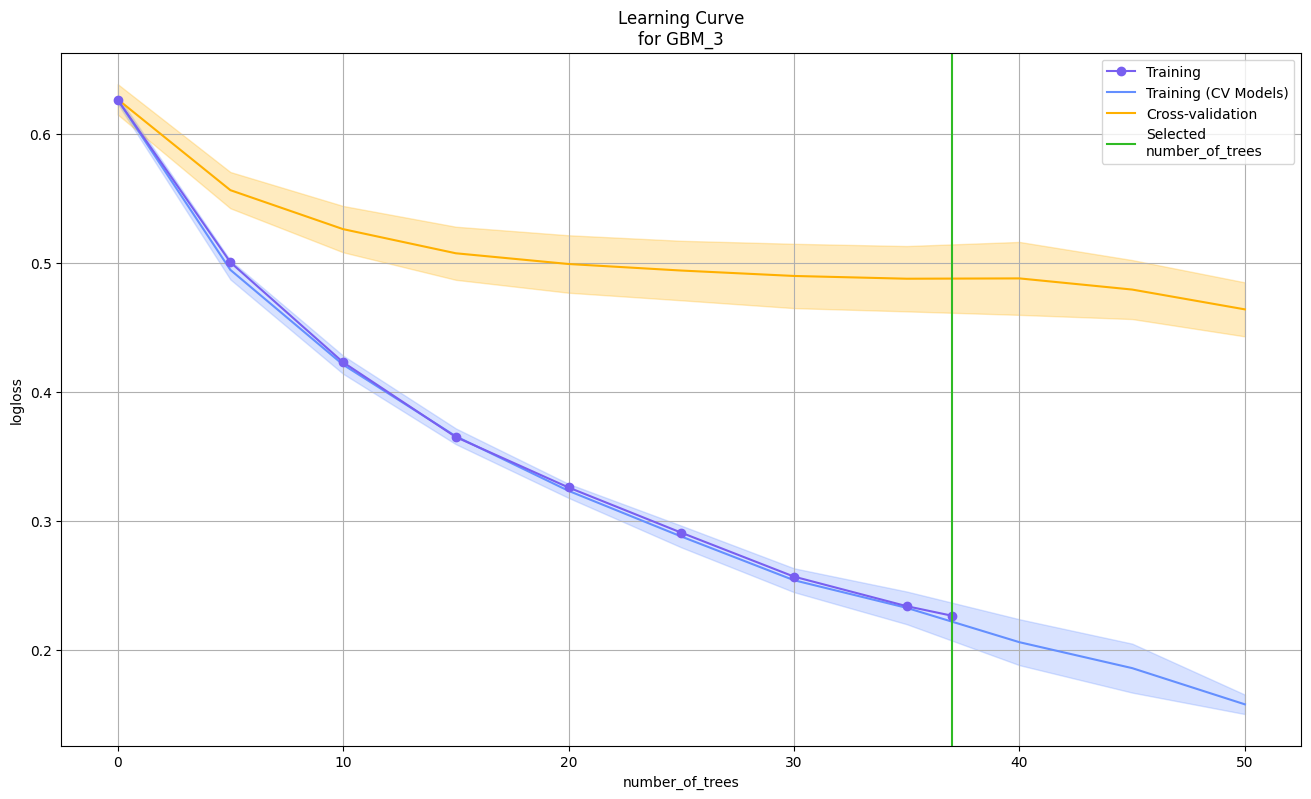

In [40]:
learning_curve_plot = model.learning_curve_plot()

#### Check performance

In [41]:
perf = model.model_performance(df_h_test)
print(perf.accuracy()[0][1])
perf.confusion_matrix()

0.7866666666666666


,False,True,Error,Rate
False,199.0,281.0,0.5854,(281.0/480.0)
True,47.0,973.0,0.0461,(47.0/1020.0)
Total,246.0,1254.0,0.2187,(328.0/1500.0)


#### Model Explainability

Feature importance of a specific model

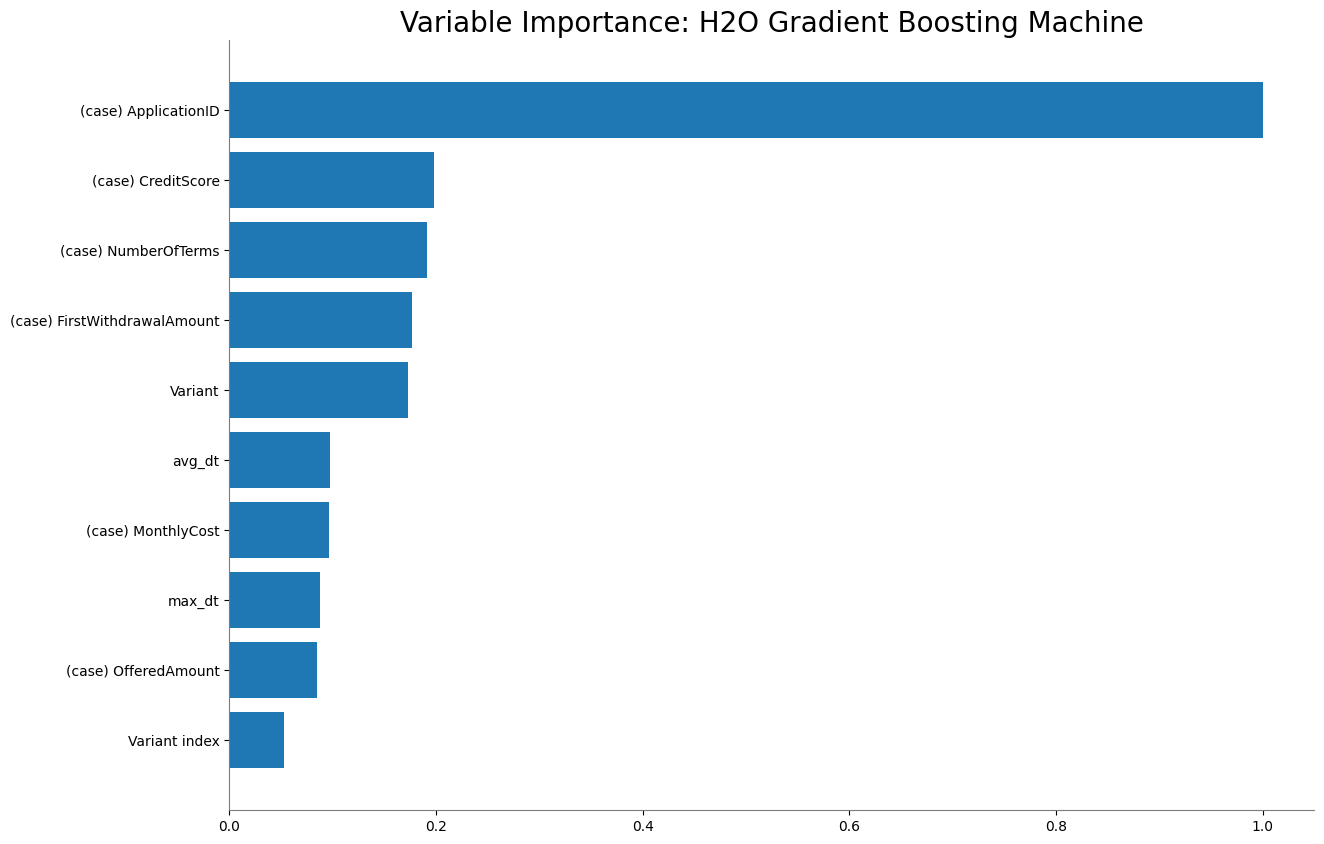

<Figure size 640x480 with 0 Axes>

In [42]:
h2o.get_model("GBM_3_AutoML_7_20240118_81916").varimp_plot()

Show feature importance between all the models

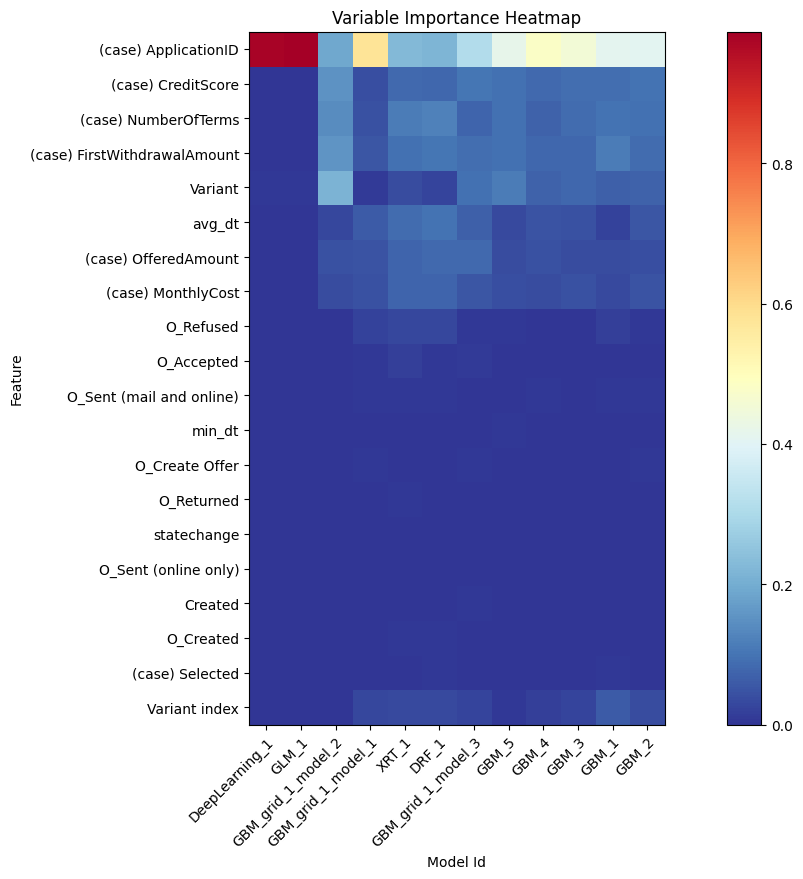

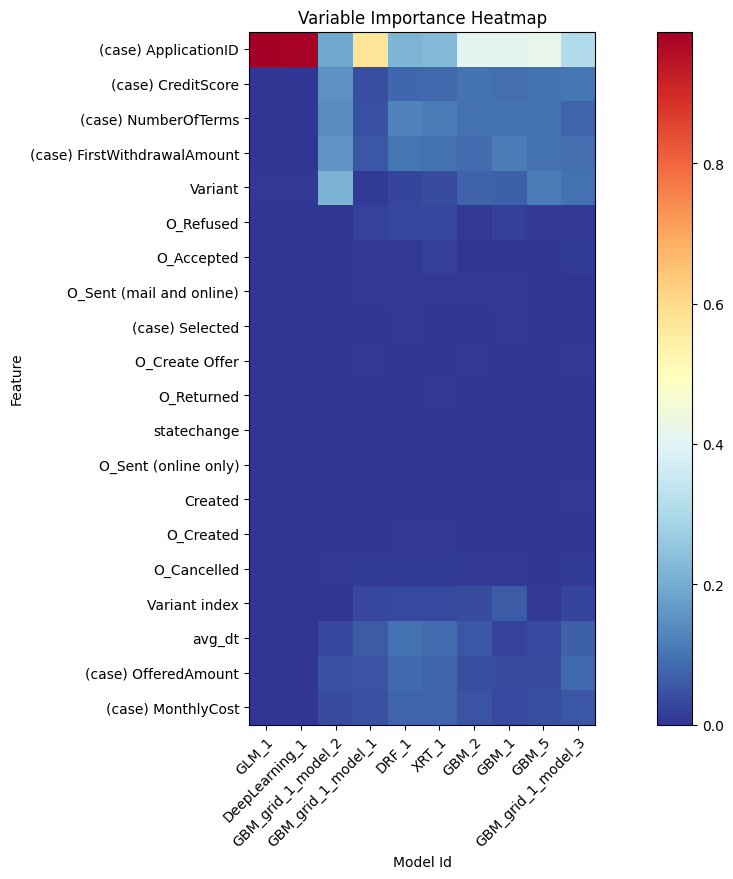

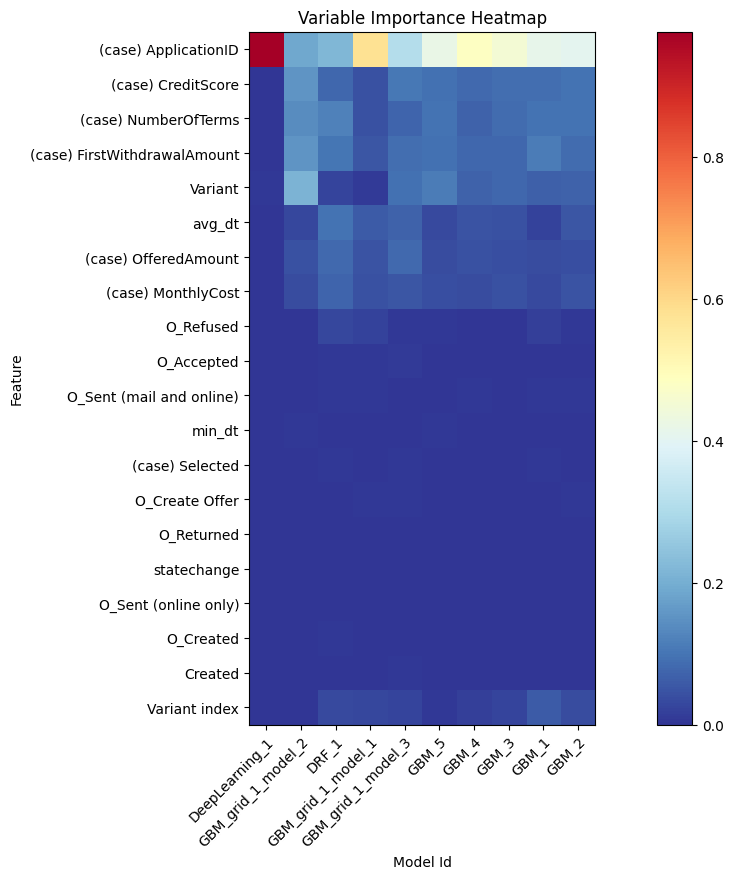

In [43]:
va_plot = aml.varimp_heatmap()

va_plot = h2o.varimp_heatmap(aml.leaderboard.sort("auc").head(10))

# or even extended leaderboard can be used
va_plot = h2o.varimp_heatmap(h2o.automl.get_leaderboard(aml, extra_columns="training_time_ms").sort("training_time_ms").head(10))

## Model Retraining 

We can then retrain the model taking out the less important features

In [48]:
df = pd.read_csv("hmw/Sampled_BPIC17_offer_log.csv")

input = {
    "Case ID" : "caseid",
    "Activity" : "activity" ,
    "Resource" : "resource" ,
    "Complete Timestamp": "ts",
    "(case) Accepted" : "y"  #Needs to be 1 for each Case
}

# Change columns name
df.rename(columns=input,inplace = True)

# Timestamp value in df
df["ts"] = pd.to_datetime(df["ts"])

df["dt"] = Utils.dt(df) # Thisneed to be improved
df.drop("ts",axis=1,inplace = True)

##DROP THE USLESS COLUMNS
df.drop("resource",axis=1,inplace = True)

df,model = Utils.predict_null_value(colum="OfferID",df=df)

df = Utils.prod_nan_with_treshold(df)

df_grouped = df.groupby(["caseid"]).agg(list).reset_index()
df_grouped = Utils.reduce_list_columns(df_grouped)
df_grouped = df_grouped.drop(['EventID','OfferID'],axis=1)
df_grouped = df_grouped.drop(['OfferID_was_null'],axis=1)
df_grouped_agg = Utils.aggregation_encoding(df_grouped,df)

In [49]:
df_grouped_agg["max_dt"] = df_grouped_agg["max_dt"].map(lambda x : x.seconds)
df_grouped_agg["min_dt"] = df_grouped_agg["min_dt"].map(lambda x : x.seconds)
df_grouped_agg["avg_dt"] = df_grouped_agg["avg_dt"].map(lambda x : x.seconds)

In [50]:
h2o.init()

X_train, X_test = train_test_split(df_grouped_agg, test_size=0.3)

df_h_train = h2o.H2OFrame(X_train)
df_h_test = h2o.H2OFrame(X_test)


x = df_h_train.columns
y = "y"
x.remove(y)


df_h_train[y] = df_h_train[y].asfactor()
df_h_train[y] = df_h_train[y].asfactor()

aml = H2OAutoML(nfolds = 10, max_models=15, seed=1,max_runtime_secs= 120,balance_classes=True)
aml.train(x=x, y=y, training_frame=df_h_train)


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,7 hours 54 mins
H2O_cluster_timezone:,Europe/Rome
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,"28 days, 15 hours and 55 minutes"
H2O_cluster_name:,anadrmic
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.364 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
08:26:54.29: AutoML: XGBoost is not available; skipping it.
08:26:54.36: _train param, Dropping bad and constant columns: [EventOrigin, lifecycle:transition, caseid]

███████████████
08:27:22.481: _train param, Dropping bad and constant columns: [EventOrigin, lifecycle:transition, caseid]

█
08:27:24.655: _train param, Dropping bad and constant columns: [EventOrigin, lifecycle:transition, caseid]

██
08:27:28.474: _train param, Dropping bad and constant columns: [EventOrigin, lifecycle:transition, caseid]

█
08:27:30.866: _train param, Dropping bad and constant columns: [EventOrigin, lifecycle:transition, caseid]

█
08:27:33.463: _train param, Dropping bad and constant columns: [EventOrigin, lifecycle:transition, caseid]

██
08:27:36.331: _train param, Dropping bad and constant co

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_3_AutoML_9_20240118_82654


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    34                 34                          88792                  8            8            8             69            128           98.1765

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.07301735477840787
RMSE: 0.2702172362718705
LogLoss: 0.2692591552623139
Mean Per-Class Error: 0.021477362290918643
AUC: 0.9978664423121031
AUCPR: 0.9980208898648003
Gini: 0.9957328846242062

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6821627000115636
       False    True    Error    Rate
-----  -------  ------  -------  --------------
False  2364     40      0.0166   (40.0/2404.0)
True   63       2331    0.0263   (63.0/2394.0)
Total  2427     2371    0.0215   (103.0/4798.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.682163     0.978384  160
max f2                       0.611568     0.979411  182
max f0point5                 0.724656     0.988302  148
max accuracy                 0.682163     0.978533  160
max precision                0.98692      1         0
max recall                   0.432684     1         241
max specificity              0.98692      1         0
max absolute_mcc             0.722002     0.957178  149
max min_per_class_accuracy   0.673554     0.97619   163
max mean_per_class_accuracy  0.682163     0.978523  160
max tns                      0.98692      2404      0
max fns                      0.98692      2391      0
max fps                      0.0864166    2404      399
max tps                      0.432684     2394      241
max tnr                      0.98692      1         0
max fnr                      0.98692      0.998747  0
max fpr                      0.0864166    1         399
max tpr                      0.432684     1         241

Gains/Lift Table: Avg response rate: 49.90 %, avg score: 60.85 %
group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ----------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100042                   0.980768           2.00418     2.00418            1                0.982886  1                           0.982886            0.0200501       0.0200501                  100.418   100.418            0.0200501
2        0.0200083                   0.97875            2.00418     2.00418            1                0.979863  1                           0.981374            0.0200501       0.0401003                  100.418   100.418            0.0401003
3        0.0300125                   0.976581           2.00418     2.00418            1                0.977613  1                           0.980121            0.0200501       0.0601504                  100.418   100.418            0.0601504
4        0.0400167                   0.97423            2.00418     2.00418            1                0.975487  1                           0.978962            0.0200501       0.0802005                  100.418   100.418            0.0802005
5        0.0500208                   0.971988           2.00418     2.00418            1                0.973118  1 

In [51]:
aml.leaderboard.head(5)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_3_AutoML_9_20240118_82654,0.811791,0.491999,0.886005,0.31898,0.39767,0.158141
GBM_2_AutoML_9_20240118_82654,0.807214,0.494627,0.88035,0.273313,0.399868,0.159894
GBM_5_AutoML_9_20240118_82654,0.804845,0.49478,0.882399,0.300807,0.400849,0.16068
GBM_1_AutoML_9_20240118_82654,0.802616,0.499784,0.876843,0.27846,0.402959,0.162376
GBM_4_AutoML_9_20240118_82654,0.802132,0.505239,0.873909,0.300144,0.401934,0.161551


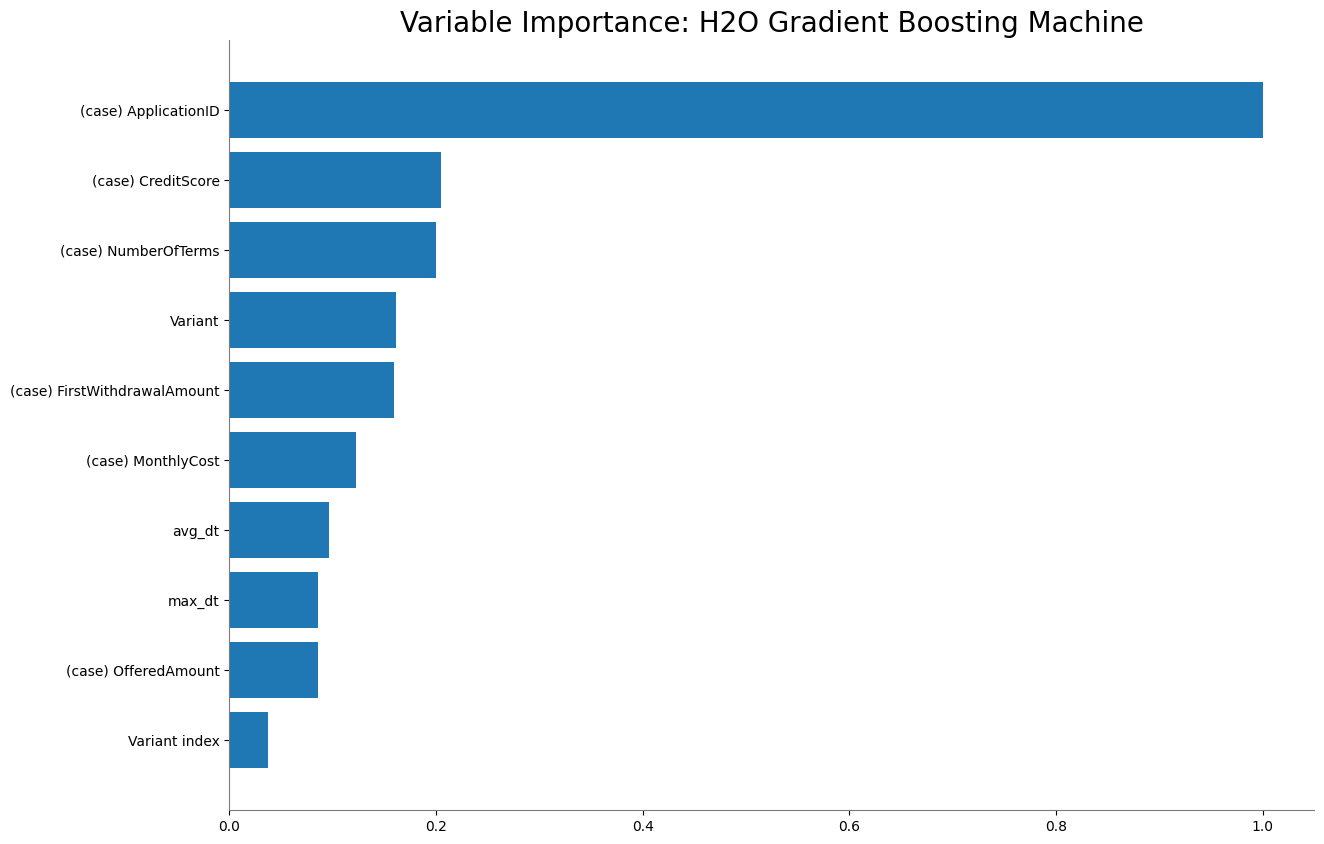

<Figure size 640x480 with 0 Axes>

In [52]:
h2o.get_model("GBM_3_AutoML_9_20240118_82654").varimp_plot()

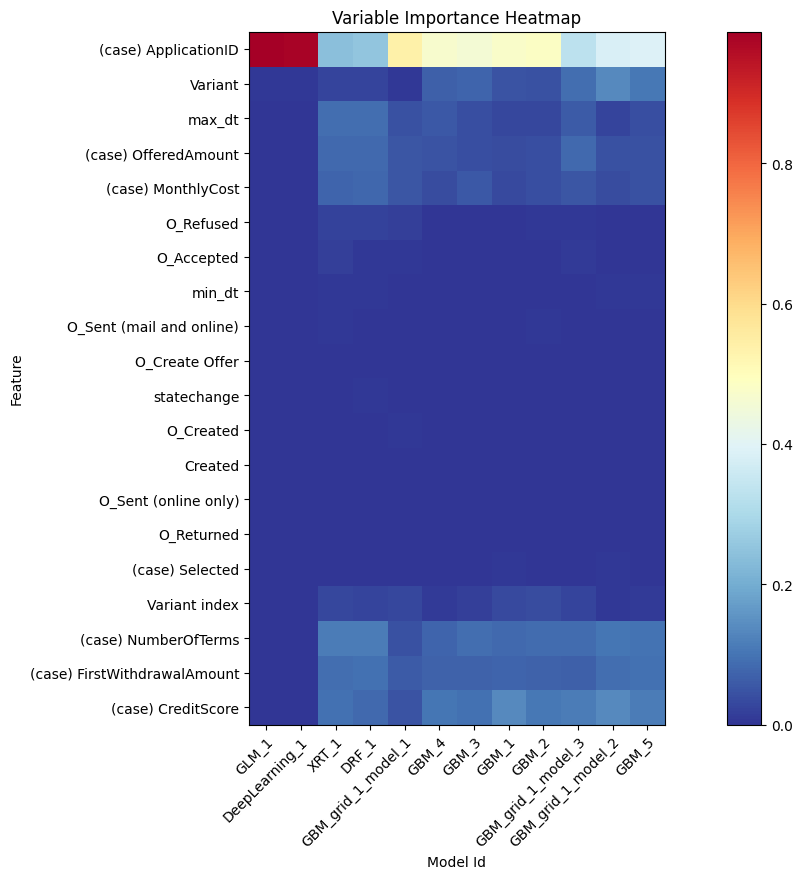

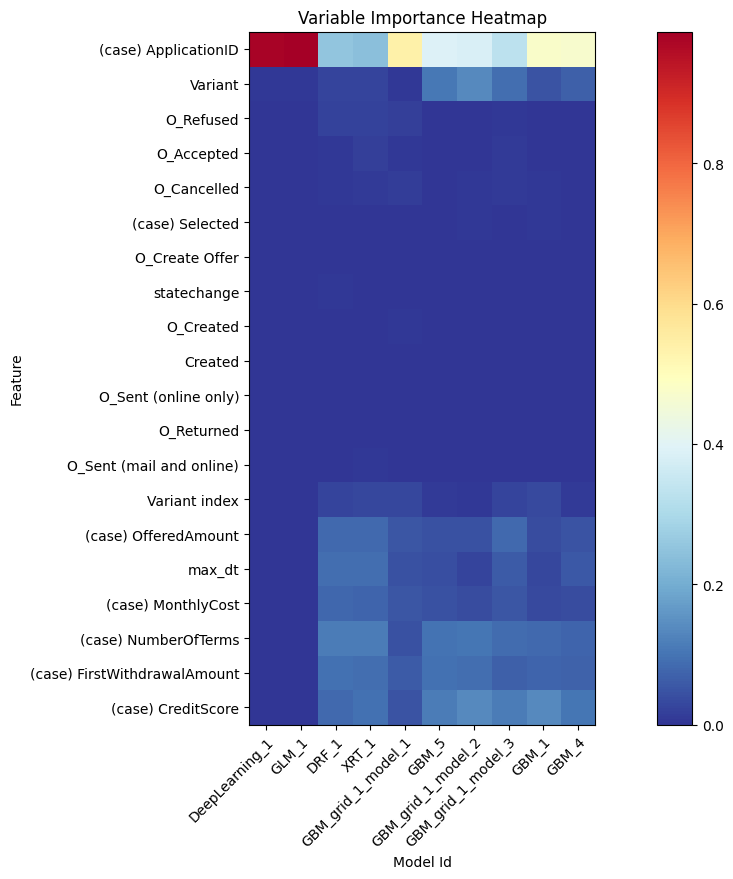

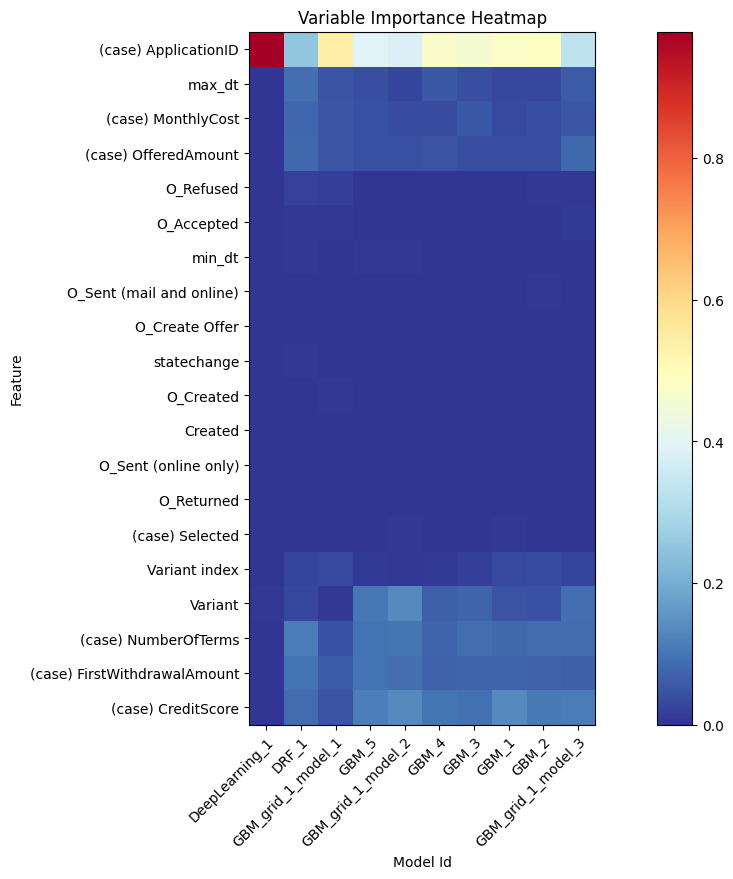

In [53]:
va_plot = aml.varimp_heatmap()

# or if some subset of the models is needed a slice of leaderboard can be used, e.g., using MAE as the sorting metric
va_plot = h2o.varimp_heatmap(aml.leaderboard.sort("auc").head(10))

# or even extended leaderboard can be used
va_plot = h2o.varimp_heatmap(h2o.automl.get_leaderboard(aml, extra_columns="training_time_ms").sort("training_time_ms").head(10))

## Evaluation of results

In [54]:
model_2 = aml.leader
perf = model_2.model_performance(df_h_test)
print(perf.accuracy()[0][1])
perf.confusion_matrix()

0.7966666666666666


,False,True,Error,Rate
False,240.0,254.0,0.5142,(254.0/494.0)
True,57.0,949.0,0.0567,(57.0/1006.0)
Total,297.0,1203.0,0.2073,(311.0/1500.0)
